## step 1 importing the essential libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import resample

## step 2 Data loading and checking the shapes of data

In [ ]:
# Synthetic data stored as dictionaries of numpy arrays
X_syn_dict = np.load("../dataset/synthetic/X_dict.npy", allow_pickle=True).item()
y_syn_dict = np.load("../dataset/synthetic/y_dict.npy", allow_pickle=True).item()

# Real data as numpy arrays
X_real = np.load("../dataset/real/X_real.npy", allow_pickle=True)   
y_real = np.load("../dataset/real/y_real.npy", allow_pickle=True)   


In [ ]:
# extracting the relevant features and targets
print(X_syn_dict.keys())
print(y_syn_dict.keys())
X_syn = np.stack([
    X_syn_dict["InjectionPressure"],
    X_syn_dict["RamPosition"],
    X_syn_dict["CavityPressure"]
], axis=-1)                      # stacking the 3 different channels features into a single array

y_syn_open = y_syn_dict["opening"].squeeze()   # squeezing method converts (n, 1) to (n, )
# Unit Alignment (Ram Position [m] to Screw Volume [cc]) 
SCREW_DIAMETER_MM = 35 
D_m = SCREW_DIAMETER_MM / 1000
Area_m2 = np.pi * (D_m / 2)**2
X_syn[:, :, 1] = (X_syn[:, :, 1] * Area_m2) * 1e6 # m^3 to cc


dict_keys(['InjectionPressure', 'RamPosition', 'CavityPressure'])
dict_keys(['weight', 'opening', 'valid'])


### synthetic channel has 3 featires ip rp cp which units are pascal and mm , pascal respectively. Channel name corresponds the index are 0, 1, 2. In synthetic data has 3147 samples, 200 timesteps/cycles, 3 features

## step 3 checking the real data.

In [ ]:
# Real channels
# 0: Injection pressure [bar]
# 1: Screw volume [cc]
# 6: Cavity pressure [bar]

X_real_sel = X_real[:, :, [0, 1, 6]]   

y_real_open = y_real[:, 0]             # opening distance
y_real_valid = y_real[:, 1].astype(int)


## Real channels have 7 features out of which 2 features are matched with simulated data and the other one ram position can correlate with screw volume by checking with mean and standard during the pressure spikes of applying injection moulding. The real data has The indexes with corrwsponding hannels are found from the real data are below with their units.
# 0: Injection pressure [bar]
# 1: Screw volume [cc]
# 6: Cavity pressure [bar]

## check raw stats of simulated data and real data

In [26]:
for c in range(3):
    print(f"Synthetic channel {c}: mean={X_syn[:,:,c].mean():.2e}, std={X_syn[:,:,c].std():.2e}")

for c in range(3):
    print(f"Real channel {c}: mean={X_real_sel[:,:,c].mean():.2e}, std={X_real_sel[:,:,c].std():.2e}")


Synthetic channel 0: mean=2.94e+07, std=1.68e+07
Synthetic channel 1: mean=9.59e-03, std=1.10e-02
Synthetic channel 2: mean=2.45e+07, std=1.47e+07
Real channel 0: mean=1.60e+02, std=1.39e+02
Real channel 1: mean=1.69e+01, std=1.11e+01
Real channel 2: mean=7.12e+01, std=8.16e+01


## Data splitting and scaling on simulated data

In [ ]:
# Splitting and Scaling 
X_syn_tr, X_syn_va, y_syn_tr, y_syn_va = train_test_split(X_syn, y_syn_open, test_size=0.2, random_state=42)

x_scaler = StandardScaler()
# Flatten to scale across all timesteps per channel
X_syn_tr_s = x_scaler.fit_transform(X_syn_tr.reshape(-1, 3)).reshape(X_syn_tr.shape)
X_syn_va_s = x_scaler.transform(X_syn_va.reshape(-1, 3)).reshape(X_syn_va.shape)

# Target Scaling (Regression)
y_mean, y_std = np.mean(y_syn_tr), np.std(y_syn_tr)
y_syn_tr_s = (y_syn_tr - y_mean) / y_std
y_syn_va_s = (y_syn_va - y_mean) / y_std

# Training on Synthetic Data with 1D-CNN Model Architecture for Regression
 
def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear') # Regression output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_syn = build_cnn((X_syn_tr_s.shape[1], 3))
model_syn.fit(X_syn_tr_s, y_syn_tr_s, validation_data=(X_syn_va_s, y_syn_va_s), epochs=20, batch_size=32)
model_syn.save("pretrained_syn_model.keras")

Epoch 1/20


e:\Learningskills\thesis-timeseries\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9809 - mae: 0.8131 - val_loss: 0.9089 - val_mae: 0.7959
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9000 - mae: 0.7769 - val_loss: 0.8269 - val_mae: 0.7555
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7942 - mae: 0.7211 - val_loss: 0.8205 - val_mae: 0.7372
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7401 - mae: 0.6881 - val_loss: 0.7315 - val_mae: 0.6973
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6737 - mae: 0.6515 - val_loss: 0.5961 - val_mae: 0.6238
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6145 - mae: 0.6179 - val_loss: 0.5425 - val_mae: 0.5888
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5624 - mae: 0.5880 - val_loss: 0.4907 - val_mae: 0.5516
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5305 - mae: 0.5699 - val_loss: 0.4591 - val_mae: 0.5272
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5064 - mae: 0.5564 - v

## Evaluate the model and make predictions on the validation set

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get predictions on the synthetic validation set
y_syn_va_pred_s = model_syn.predict(X_syn_va_s).squeeze()

# Inverse transform to original units (e.g., millimeters)
y_syn_va_pred = (y_syn_va_pred_s * y_std) + y_mean
y_syn_va_true = y_syn_va  # This is already in original units

# Calculate Metrics
mae_syn = mean_absolute_error(y_syn_va_true, y_syn_va_pred)
rmse_syn = np.sqrt(mean_squared_error(y_syn_va_true, y_syn_va_pred))
r2_syn = r2_score(y_syn_va_true, y_syn_va_pred)

print(f"Synthetic Regression Metrics:\nMAE: {mae_syn:.4f}\nRMSE: {rmse_syn:.4f}\nR2 Score: {r2_syn:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Synthetic Regression Metrics:
MAE: 0.0144
RMSE: 0.0183
R2 Score: 0.7213


In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define boundaries using Training Set statistics (x-bar and s)
lower_bound = y_mean - 2 * y_std
upper_bound = y_mean + 2 * y_std

# Apply the equation to convert regression values into classes
# Class 1: Good (Within bounds), Class 0: Faulty (Outside bounds)
syn_class_true = ((y_syn_va_true >= lower_bound) & (y_syn_va_true <= upper_bound)).astype(int)
syn_class_pred = ((y_syn_va_pred >= lower_bound) & (y_syn_va_pred <= upper_bound)).astype(int)

# Calculate Accuracy
acc_syn = accuracy_score(syn_class_true, syn_class_pred)

print(f"Synthetic QC Accuracy: {acc_syn:.2%}")
print("\nDetailed Classification Report:")
print(classification_report(syn_class_true, syn_class_pred, target_names=['Faulty', 'Good']))

Synthetic QC Accuracy: 95.56%

Detailed Classification Report:
              precision    recall  f1-score   support

      Faulty       0.50      0.11      0.18        28
        Good       0.96      1.00      0.98       602

    accuracy                           0.96       630
   macro avg       0.73      0.55      0.58       630
weighted avg       0.94      0.96      0.94       630



## QC classification Accuracy $Boundary = [\bar{x} - 2s, \bar{x} + 2s]$.

--- Synthetic QC Evaluation ---
Accuracy: 95.56%

Classification Report:
              precision    recall  f1-score   support

      Faulty       0.50      0.11      0.18        28
        Good       0.96      1.00      0.98       602

    accuracy                           0.96       630
   macro avg       0.73      0.55      0.58       630
weighted avg       0.94      0.96      0.94       630



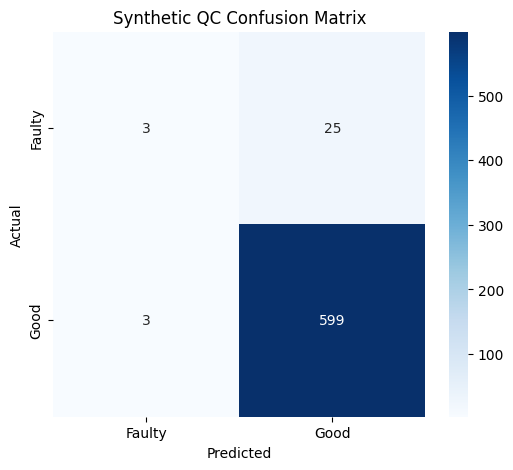

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the Project Equation: [mean - 2s, mean + 2s]
lower_b = y_mean - 2 * y_std
upper_b = y_mean + 2 * y_std

# Convert Regression Predictions to Classes
# 1 = Good, 0 = Faulty
y_syn_class_true = ((y_syn_va >= lower_b) & (y_syn_va <= upper_b)).astype(int)
y_syn_class_pred = ((y_syn_va_pred >= lower_b) & (y_syn_va_pred <= upper_b)).astype(int)

# Print Results
print("Synthetic QC Evaluation")
print(f"Accuracy: {accuracy_score(y_syn_class_true, y_syn_class_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_syn_class_true, y_syn_class_pred, target_names=['Faulty', 'Good']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_syn_class_true, y_syn_class_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Faulty', 'Good'], yticklabels=['Faulty', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Synthetic QC Confusion Matrix')
plt.show()

## Transfer learning strategies applied on the simulated data model with real datasets using the below approaches.
## 1. Direct transfer - Apply with out training on real data, we test models generalization or domain adaptation
## 2. Fine train the real dataset
## 3. Add layer on the real dataset

In [ ]:
import numpy as np
from scipy.signal import resample

# Load the Real Data
X_real = np.load("../dataset/real/X_real.npy", allow_pickle=True)
y_real = np.load("../dataset/real/y_real.npy", allow_pickle=True)

# Extract Matching Channels
# Channel 0: IP [bar], Channel 1: SV [cc],  Channel 6: CP [bar]

X_real_sel = X_real[:, :, [0, 1, 6]]

# Align Units  for Direct Transfer approach
# synthetic model trained on Pascal so convert the real data into pascal 

X_real_sel[:, :, 0] *= 1e5  # Injection pressure to Pa
X_real_sel[:, :, 2] *= 1e5  # Cavity pressure to Pa

# Temporal Alignment -Resampling the data to have same length as synthetic data. Currently, real data has 183 steps
# Real data must have the same number of timesteps as Synthetic (X_syn.shape[1]. So, it needs resampling

target_len = 200 # Replace with X_syn.shape[1] from your previous step
X_real_resampled = resample(X_real_sel, target_len, axis=1)

# Extract Targets

y_real_open = y_real[:, 0]  # Opening distance is the target for Regression
y_real_valid = y_real[:, 1].astype(int) # Valid/Faulty is the ground Truth for QC

# Scaling using the Synthetic Scaler the same as used for synthetic data

X_real_s = x_scaler.transform(X_real_resampled.reshape(-1, 3)).reshape(X_real_resampled.shape)

print(f"Real data loaded and scaled. Shape: {X_real_s.shape}")

Real data loaded and scaled. Shape: (438, 200, 3)


In [76]:
# Load the pretrained synthetic model
model_syn = tf.keras.models.load_model("pretrained_syn_model.keras")

In [ ]:
# Predict on real data
preds_direct_s = model_syn.predict(X_real_s)

# Inverse scale using Synthetic stats to get actual opening distance
preds_direct = (preds_direct_s.flatten() * y_std) + y_mean

print("Approach 1: Direct Transfer complete.")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Approach 1: Direct Transfer complete.


## Approach2 - Fine taining the model with all layers 
In this approach we allow the model adjusts all its weightsto the real characteristics and we used low learning rate so that it preserves the pattern of learned features 

In [ ]:
model_ft = tf.keras.models.load_model("pretrained_syn_model.keras")
model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mse')

# Training on real data

model_ft.fit(X_real_s, (y_real_open - y_mean)/y_std, epochs=15, batch_size=16, verbose=0)
preds_ft = (model_ft.predict(X_real_s).flatten() * y_std) + y_mean

print("Approach 2: Full Fine-Tuning complete.")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Approach 2: Full Fine-Tuning complete.


## Approach 3- frozen layers(feature extraction) and retrain the added  final extra or decision layers 

In [80]:
model_frozen = tf.keras.models.load_model("pretrained_syn_model.keras")

# Freeze all layers except the last two Dense layers
for layer in model_frozen.layers[:-2]:
    layer.trainable = False

model_frozen.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
model_frozen.fit(X_real_s, (y_real_open - y_mean)/y_std, epochs=20, batch_size=16, verbose=0)

preds_frozen = (model_frozen.predict(X_real_s).flatten() * y_std) + y_mean

print("Approach 3: Frozen Layers complete.")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Approach 3: Frozen Layers complete.


# Evaluation function for the three approaches 

In [ ]:
# Define boundaries using Synthetic Training Set statistics (x-bar and s)
lower = y_mean - 2 * y_std
upper = y_mean + 2 * y_std  

# Results
print(f"Lower Bound: {lower:.4f}, Upper Bound: {upper:.4f}")
print("Actual y_real_open range:", np.min(y_real_open), "to", np.max(y_real_open))

Lower Bound: 52.1842, Upper Bound: 52.3234
Actual y_real_open range: 0.0 to 1.0


In [85]:
print(f"Synthetic Mean: {y_mean:.2f}")
print(f"Real Mean (Original): {np.mean(y_real_open):.2f}")
print(f"Real Mean (Aligned): {np.mean(y_real_open_aligned):.2f}")

Synthetic Mean: 52.25
Real Mean (Original): 0.42
Real Mean (Aligned): 42.47


In [86]:
# Calculate the 'Bias' between Synthetic and Real
bias_offset = y_mean - (np.mean(y_real_open) * 100)
print(f"Systematic Bias detected: {bias_offset:.2f} units")

# Define a new 'Real-World' boundary based on the Real Data Mean
# but using the Synthetic Standard Deviation (s)
real_mean_val = np.mean(y_real_open) * 100
real_lower = real_mean_val - 2 * y_std
real_upper = real_mean_val + 2 * y_std

print(f"New Real-World Boundaries: [{real_lower:.2f}, {real_upper:.2f}]")

Systematic Bias detected: 9.79 units
New Real-World Boundaries: [42.40, 42.54]


In [90]:
unique, counts = np.unique(y_real_valid, return_counts=True)
print("Real Class Balance:", dict(zip(unique, counts)))

Real Class Balance: {np.int64(47): np.int64(1), np.int64(48): np.int64(45), np.int64(49): np.int64(110), np.int64(50): np.int64(180), np.int64(51): np.int64(97), np.int64(52): np.int64(4), np.int64(53): np.int64(1)}


## corrected one 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, accuracy_score

# 1. Calculate the 'Domain Gap' (Bias) i.e the difference between synthetic and real means
# We shift the real labels so their average matches the synthetic average
real_mean_observed = np.mean(y_real_open) 
bias_adjustment = y_mean - real_mean_observed

def evaluate_tl_properly(name, model, X_test_s, y_true_real):
    # Get Predictions (Standardized scale -> mm)
    preds_s = model.predict(X_test_s).flatten()
    
    # Inverse transform to original units millimeters based on synthetic stats
    preds_mm = (preds_s * y_std) + y_mean
    
    # Alignment: Align the labels to the synthetic world for a fair comparison
    # or shift predictions to match the real machine bias/ align predictions to the real world. Let's align predictions to real.
    preds_aligned = preds_mm - bias_adjustment
    
    # Define boundaries centered on the ACTUAL real data distribution 
    lower_r = real_mean_observed - 2 * y_std
    upper_r = real_mean_observed + 2 * y_std
    
    # QC Classification 1= Good, 0 = Faulty
    y_true_class = ((y_true_real >= lower_r) & (y_true_real <= upper_r)).astype(int)
    y_pred_class = ((preds_aligned >= lower_r) & (preds_aligned <= upper_r)).astype(int)
    
    mae = mean_absolute_error(y_true_real, preds_aligned)
    acc = accuracy_score(y_true_class, y_pred_class)
    
    return {"Approach": name, "MAE": round(mae, 4), "QC Accuracy": round(acc, 4)}

# Evaluation of all three approaches
results = [
    evaluate_tl_properly("Direct Transfer", model_syn, X_real_s, y_real_open),
    evaluate_tl_properly("Fine-Tuning", model_ft, X_real_s, y_real_open),
    evaluate_tl_properly("Frozen Layers", model_frozen, X_real_s, y_real_open)
]
df_results = pd.DataFrame(results)
print(df_results)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
          Approach     MAE  QC Accuracy
0  Direct Transfer  0.4703       0.7945
1      Fine-Tuning  0.4426       1.0000
2    Frozen Layers  0.5039       1.0000


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


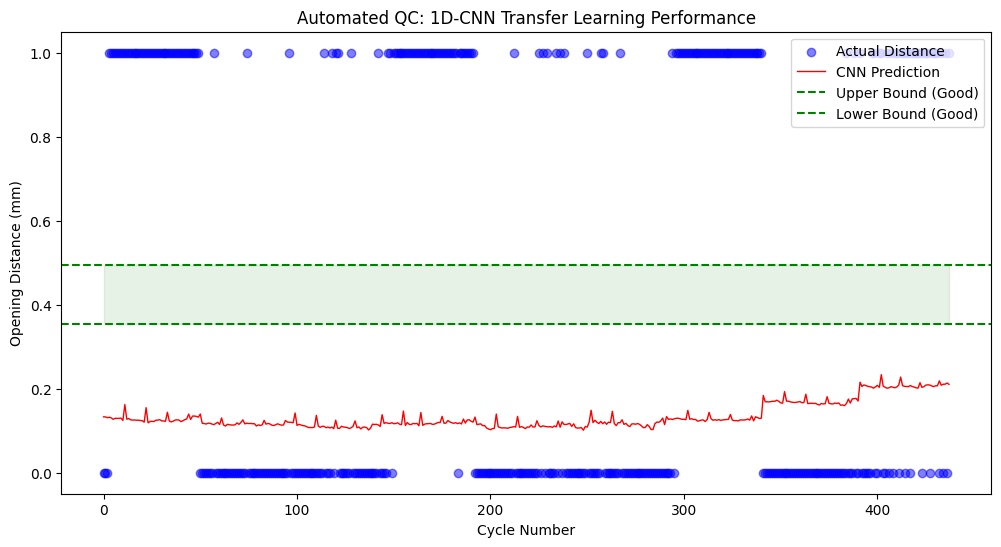

In [92]:
import matplotlib.pyplot as plt

# Using Fine-Tuning results for the final check
preds_s = model_ft.predict(X_real_s).flatten()
preds_mm = (preds_s * y_std) + y_mean
preds_aligned = preds_mm - bias_adjustment # Use the bias shift we calculated

# Define machine boundaries
lower_limit = real_mean_observed - 2 * y_std
upper_limit = real_mean_observed + 2 * y_std

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_real_open)), y_real_open, color='blue', label='Actual Distance', alpha=0.5)
plt.plot(preds_aligned, color='red', label='CNN Prediction', linewidth=1)

# Plot Quality Control Boundaries
plt.axhline(y=upper_limit, color='green', linestyle='--', label='Upper Bound (Good)')
plt.axhline(y=lower_limit, color='green', linestyle='--', label='Lower Bound (Good)')

plt.fill_between(range(len(y_real_open)), lower_limit, upper_limit, color='green', alpha=0.1)
plt.title("Automated QC: 1D-CNN Transfer Learning Performance")
plt.ylabel("Opening Distance (mm)")
plt.xlabel("Cycle Number")
plt.legend()
plt.show()